# Sentiment Analysis Using Keras

In [3]:
#Access database and get dataset
import pandas as pd
import sqlite3
conn = sqlite3.connect('capstone.db')
# tblGame , tblMovie, tblReview, tblTVShow
# load games dataset
games = pd.read_sql_query("SELECT * FROM tblGame;", conn)
games['gameID'] = games.index + 1
reviews = pd.read_sql_query("SELECT * FROM tblReview;", conn)

In [4]:
#filter reviews so that we only use critic reviews
critic_reviews = reviews[reviews['reviewType'] == 'c']


In [5]:
#function to clean text

import re

def cleaning_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'\\r, u', ' ', sentence)
    sentence = re.sub(r'\\', "'", sentence)
    sentence = sentence.split()
    sentence = [re.sub("([^a-z0-9' \t])", '', x) for x in sentence]
    cleaned = [s for s in sentence if s != '']
    cleaned = ' '.join(cleaned)
    return cleaned


#apply function to dataset
critic_reviews['textClean'] = critic_reviews.apply(lambda row: cleaning_text(row['text'].encode("utf8")), axis=1)

/Users/Daniel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


477672
75.0
19.3140135003
106045
96010


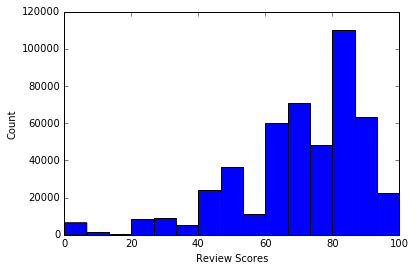

In [6]:
#Basic EDA for dataset

%matplotlib inline
import matplotlib.pyplot as plt

print len(critic_reviews)
print critic_reviews['score'].median()
print critic_reviews['score'].std()
plt.hist(critic_reviews['score'], bins = 15)
plt.xlabel('Review Scores')
plt.ylabel('Count')
print len(critic_reviews[critic_reviews['score'] >= (85)])
print len(critic_reviews[critic_reviews['score'] <= (55)])

In [7]:
#label reviews 85 or over as positive and 55 or lower as negative

def binarizer(x):
    if x <= 55:
        return 0
    if x >= 85:
        return 1
    
critic_reviews['overall'] = critic_reviews['score'].apply(lambda row: binarizer(row))

/Users/Daniel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
import numpy as np

#drop rows with NA values for overall (scores between 55 and 85)
subset = critic_reviews[pd.notnull(critic_reviews['overall'])].reset_index()

length_df = subset
length_df['length'] = pd.DataFrame(subset['textClean'].apply(lambda x: len(x.split(' '))))
over = length_df[length_df['length'] > 2]
#print over.sort_values('length')
print len(over)

subset = over.drop(['author', 'text', 'score', 'date', 'thumbsUp', 'thumbsDown', 'reviewType'], axis = 1).reset_index()
print subset.head()
subset['overall'].value_counts()

195823
   level_0  index  gameID  movieID  tvShowID           publication  \
0        0      4     1.0      NaN       NaN  Digitally Downloaded   
1        1      5     2.0      NaN       NaN         God is a Geek   
2        2     31     2.0      NaN       NaN          PSX-Sense.nl   
3        3     32     2.0      NaN       NaN           Push Square   
4        4     33     2.0      NaN       NaN   We Got This Covered   

                                           textClean  overall  length  
0  it may sound like im being harsh on ginger but...      0.0      69  
1  jojos bizarre adventure eyes in heaven feature...      1.0      21  
2  the amount of fan service is both admirable an...      0.0      44  
3  fun for a few bouts now and then this is a bra...      0.0      37  
4  fans of the source material will find plenty o...      0.0      43  


1.0    105656
0.0     90167
Name: overall, dtype: int64

In [9]:
from collections import Counter
#results = set()
results = Counter()
subset['textClean'].str.lower().str.split().apply(results.update)

#number of unique words, just over 100,000
print len(results)

100038


In [10]:
# cut texts after this number of words 
max_length = 188
max_features = 100038
batch_size = 32

In [11]:
#tokenize text into integers

from keras.preprocessing import text
import keras 

tk = text.Tokenizer(max_features, filters=keras.preprocessing.text.base_filter(), split=" ")
tk.fit_on_texts(subset['textClean'])

#create data set, both features and labels
x = tk.texts_to_sequences(subset['textClean'])
y = subset['overall']

In [12]:
#pad sequences with zeros so that all reviews are the same length
x = sequence.pad_sequences(x, maxlen = max_length, padding = 'post')

In [13]:
x[1]

array([30743,  1669,   151,  1063,     8,  2550,   233,    49,   164,
           3,     2,  1104,    62,   326,   134,   183,    23,     5,
          80,  4333,    64,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [14]:
#Divide dataset into train and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
x, y, test_size=0.2, random_state=42)

In [15]:
print len(X_train), len(X_test), len(y_train), len(y_test)
print X_train.shape
print y_train.shape
print X_test.shape
print y_test.shape

156658 39165 156658 39165
(156658, 188)
(156658,)
(39165, 188)
(39165,)


In [30]:
from keras.layers import LSTM, Dropout
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping

max_features = 100059 
max_length = 188
embedding_vector_length = 200
early_stopping_monitor = EarlyStopping(patience=0)

kernel_size = 4
filters = 64
pool_size = 4

ltsm_output_size = 64

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length = max_length))
model.add(Convolution1D(filters, kernel_size, activation='relu'))
model.add(MaxPooling1D(pool_size))
model.add(Convolution1D(filters, kernel_size, activation='relu'))
model.add(MaxPooling1D(pool_size))
model.add(Convolution1D(filters, kernel_size, activation='relu'))
model.add(MaxPooling1D(pool_size))
model.add(LSTM(ltsm_output_size, return_sequences=True)) 
model.add(LSTM(ltsm_output_size, return_sequences=True))
model.add(LSTM(ltsm_output_size))  
model.add(Dense(1, activation='sigmoid'))    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

#Fit the model
model.fit(X_train, y_train, nb_epoch=10, batch_size=64, validation_split=0.2, verbose = True, callbacks=[early_stopping_monitor])
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_10 (Embedding)         (None, 188, 200)      20011800    embedding_input_10[0][0]         
____________________________________________________________________________________________________
convolution1d_16 (Convolution1D) (None, 185, 64)       51264       embedding_10[0][0]               
____________________________________________________________________________________________________
maxpooling1d_16 (MaxPooling1D)   (None, 46, 64)        0           convolution1d_16[0][0]           
____________________________________________________________________________________________________
convolution1d_17 (Convolution1D) (None, 43, 64)        16448       maxpooling1d_16[0][0]            
___________________________________________________________________________________________

In [31]:
#save weights of neural network
weights = model.save_weights

In [37]:
input_str = 'The movie was boring. It was supposed to be a comedy, but I laughed maybe once'
rating = 8

#function to use weights of model to make prediction and provide feedback
def sentiment_predictor(input_str, rating):
    dummy = ''
    cleaned = cleaning_text(input_str)
    sequences = tk.texts_to_sequences([dummy, cleaned])
    padded_sequences = sequence.pad_sequences(sequences, maxlen = 188, padding = 'post')
    preds = model.predict(padded_sequences)


    #either 0 or 1
    
    predicted_rating = round(preds[1])
    #print predicted_rating 
    
    if rating <= 6 and predicted_rating == 1:
        return 'Are you sure about that score? It seems like you had a positive experience'
    elif rating >= 7 and predicted_rating == 0:
        return "It seems like you didn't have a positive experience, are you sure about that score?"

print input_str
print 'Rating:%s' %(rating) 
sentiment_predictor(input_str, rating)

The movie was boring. It was supposed to be a comedy, but I laughed maybe once
Rating:8


"It seems like you didn't have a positive experience, are you sure about that score?"

In [40]:
input_str = 'I loved it! Could not imagine a more perfect ending'
rating = 3
print input_str
print 'Rating:%s' %(rating) 
sentiment_predictor(input_str, rating)

I loved it! Could not imagine a more perfect ending
Rating:3


'Are you sure about that score? It seems like you had a positive experience'